In [1]:
import sys
sys.path.append('..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from myutils.matplotlib import matplotlib_seaborn_style

from src.missing_values import impute_average, extract_sequences, calculate_slope, nancov

matplotlib_seaborn_style()

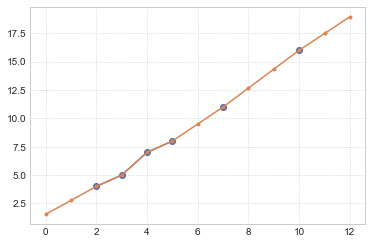

In [3]:
a = np.array([np.nan, np.nan, 4, 5, 7, 8, np.nan, 11, np.nan, np.nan, 16, np.nan, np.nan])
b = impute_average(a)

plt.plot(a, marker='o')
plt.plot(b, marker='.')

In [12]:
period = 10

In [13]:
row = a.copy()

idx = np.where(~np.isnan(row))[0]
assert len(idx) > 1

sequences = extract_sequences(idx)

sequences

[[2, 3, 4, 5], [7], [10]]

In [14]:
for seq1, seq2 in zip(sequences, sequences[1:]):
    start = seq1[-1]
    end = seq2[0]
    assert end - start > 1

    x0 = row[start]
    x1 = row[end]
    slope = (x1 - x0) / (end - start)

    for i in range(start + 1, end):
        row[i] = x0 + (i - start) * slope
        
row

array([        nan,         nan,  4.        ,  5.        ,  7.        ,
        8.        ,  9.5       , 11.        , 12.66666667, 14.33333333,
       16.        ,         nan,         nan])

In [15]:
start = sequences[0][0]
start

2

In [19]:
x0 = row[start]

ox = np.arange(start, start + period)
oy = row[ox]
slope = calculate_slope(ox, oy)

ox, oy, slope

(array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([ 4.        ,  5.        ,  7.        ,  8.        ,  9.5       ,
        11.        , 12.66666667, 14.33333333, 16.        ,         nan]),
 nan)

In [23]:
mx = np.nanmean(ox)
my = np.nanmean(oy)

vals = (ox - mx) * (oy - my)

vals

array([25.75      , 16.52777778,  6.80555556,  2.58333333,  0.11111111,
        0.63888889,  4.41666667, 11.52777778, 21.97222222,         nan])

In [21]:
nancov(ox, oy)

nan

In [26]:
n = ox.size - np.isnan(vals).sum() - 1

n

8

In [4]:
data = pd.read_csv('../data/train_clusters.csv', index_col='train')

data.head(2)

,mu,eig,both
train,,,
001А-Купе,1,3,1-3
002А-Купе,1,3,1-3


In [5]:
data['both'].value_counts()

1-3    20
0-0    17
2-1     7
0-3     7
1-2     6
0-1     2
2-0     2
1-0     1
Name: both, dtype: int64

In [2]:
data = pd.read_csv('../data/data.csv', parse_dates=['date'])

data['train'] = data['num'] + '-' + data['class']

data.head(2)

,date,days,places,price,num,class,weekday,day_name,weekend,train
0,2021-04-03,1,0.442857,3275.0,001А,Купе,5,Saturday,0,001А-Купе
1,2021-04-04,1,0.235714,3913.0,001А,Купе,6,Sunday,0,001А-Купе


In [3]:
grouped = data.groupby(['train', 'days'])['price'].mean().reset_index()\
    .pivot(index='train', columns='days', values='price')

grouped.head(2)

days,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
train,,,,,,,,,,,,,,,,,,,,,
001А-Купе,3042.617647,3081.150000,2993.452381,2971.619048,2884.000000,2852.075,2797.595238,2766.238095,2746.833333,2682.976744,...,2783.969697,2804.516129,2815.633333,2840.642857,2840.250000,2799.777778,2847.769231,2860.130435,2879.166667,2898.952381
001А-СВ,6163.615385,6205.333333,5865.261905,5943.880952,5801.926829,5888.100,5940.738095,6058.690476,6097.833333,6088.651163,...,6183.151515,6212.322581,6189.733333,6112.821429,6177.964286,6149.370370,6120.884615,6070.260870,6056.791667,6043.190476


In [4]:
grouped.shape

(144, 30)

In [6]:
trains = grouped.index.tolist()

ncols = 6
nrows = len(trains) // ncols + (len(trains) % ncols > 0)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(3 * ncols, 3 * nrows)
fig.subplots_adjust(wspace=0.5, hspace=0.6)
axes = axes.flatten()

for train, ax in zip(trains, axes):
    row = grouped.loc[train]
    ax.plot(row, c='C3', lw=2)
    ax.fill_between(row.index, row.values, row.min(), color='C3', alpha=0.15)
    
    ax.set_title(train)
    ax.set_xlabel('days to departure')
    ax.set_ylabel('avg. ticket price')
    ax.invert_xaxis()
    
for i in range(len(trains), len(axes)):
    axes[i].axis('off')
    
plt.savefig('../data/figures/price_vs_days.pdf', transparent=True, bbox_inches='tight')
plt.close()

In [10]:
grouped = data.groupby(['train', 'days'])['places'].mean().reset_index()\
    .pivot(index='train', columns='days', values='places')

grouped.head(2)

days,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
train,,,,,,,,,,,,,,,,,,,,,
001А-Купе,0.382784,0.436905,0.498810,0.549830,0.613415,0.636786,0.675510,0.707143,0.726701,0.751163,...,0.882900,0.885023,0.890238,0.902296,0.897194,0.897090,0.904121,0.897205,0.902381,0.907483
001А-СВ,0.605569,0.627604,0.686756,0.704241,0.734566,0.760352,0.764137,0.781436,0.794457,0.799964,...,0.778172,0.782258,0.795052,0.798549,0.796596,0.813079,0.808293,0.829144,0.838867,0.873512


In [11]:
grouped.shape

(144, 30)

In [14]:
trains = grouped.index.tolist()

ncols = 6
nrows = len(trains) // ncols + (len(trains) % ncols > 0)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(3 * ncols, 3 * nrows)
fig.subplots_adjust(wspace=0.5, hspace=0.6)
axes = axes.flatten()

for train, ax in zip(trains, axes):
    row = grouped.loc[train]
    ax.plot(row, c='C2', lw=2)
    ax.fill_between(row.index, row.values, row.min(), color='C2', alpha=0.15)
    
    ax.set_title(train)
    ax.set_xlabel('days to departure')
    ax.set_ylabel('avg. vacant places')
    ax.invert_xaxis()
    
for i in range(len(trains), len(axes)):
    axes[i].axis('off')
    
plt.savefig('../data/figures/places_vs_days.pdf', transparent=True, bbox_inches='tight')
plt.close()